**Exercise 1 (20 points)**

Implement a function that returns $n$ samples from a multivariate Gaussian distribution in C++ and wrap it for use in Python using `pybind11`. Use only standard C++ and the `Eigen` library. The function signature in Python  is

```python
def mvnorm(mu, Sigma, n):
    """Returns n random samples from a multivariate Gaussian distribution.
    
    mu is a mean vector
    Sigma is a covariance matrix
    
    Returns an n by p matrix, where p is the dimension of the distribution.
    """
```

In [27]:
import os
if not os.path.exists('./eigen'):
    ! git clone https://github.com/RLovelett/eigen.git

In [28]:
%matplotlib inline
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [29]:
%%file wrap10.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>
#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <Eigen/Cholesky>
#include <random>
namespace py = pybind11;
Eigen::MatrixXd mvnorm(Eigen::VectorXd mu, Eigen::MatrixXd Sigma, int n){
            std::default_random_engine generator;
            std::normal_distribution<double> distribution(0,1);

            int p = mu.size();
            Eigen::MatrixXd A(Sigma.llt().matrixL());
            Eigen::MatrixXd Sam(n,p);
            
            for(int i = 0; i < n; i++){
                Eigen::VectorXd v(p);
                for(int j = 0; j < p; j++){
                    v[j] = distribution(generator);
                }
                Sam.row(i) = mu + A*v;
            }
            return Sam;
}

PYBIND11_PLUGIN(wrap10) {
    py::module m("wrap10", "pybind11 example plugin");
    m.def("mvnorm", &mvnorm, "The random sample from Gaussian function");
    return m.ptr();
}

Overwriting wrap10.cpp


In [30]:
import cppimport
import numpy as np
cppimport.force_rebuild()
funcs = cppimport.imp("wrap10")

**Exercise 2 (20 points)**

- Consider a sequence of $n$ Bernoulli trials with success probability $p$ per trial. A string of consecutive successes is known as a success *run*. Write a function that returns the counts for runs of length $k$ for each $k$ observed in a dictionary.

For example: if the trials were [0, 1, 0, 1, 1, 0, 0, 0, 0, 1], the function should return 
```
{1: 2, 2: 1})
```

- What is the probability of observing at least one run of length 5 or more when $n=100$ and $p=0.5$?. Estimate this from 100,000 simulated experiments. Is this more, less or equally likely than finding runs of length 7 or more when $p=0.7$?

In [31]:
import collections
import numpy as np
from matplotlib import pyplot as plt

def count_run(trials):
    """Write a function that returns the counts for runs of
    length  kk  for each  kk  observed in a dictionary."""
    list = np.array(trials)
    index = np.flatnonzero((list==1))
    k = 1
    lens = []
    for i in range(0,len(index)-1):
        if index[i]+1 == index[i+1]:
            k = k+1
        elif index[i] + 1 != index[i+1]:
            lens.append(k)   
            k = 1
    #add the last one 
    lens.append(1)
    count = collections.Counter(lens)
    return dict(count)   
        

In [32]:
list =  [0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
count_run(list)

{1: 2, 2: 1}

In [33]:
from scipy.stats import bernoulli
np.random.seed(12345)
k = 0
for i in range(100000):
    n, p = 100, .5  # number of trials, probability of each trial   
    r = bernoulli.rvs(p, size=100)   
    count = count_run(r)
    lengths = np.fromiter(iter(count.keys()), dtype=int)
    index = [i for i,x in enumerate(lengths) if x < 5]
    runs = np.fromiter(iter(count.values()), dtype=int)
    if np.dot(runs[index], lengths[index]) < np.sum(r):
        k  = k + 1
float(k/100000)

0.89855

In [34]:
k = 0
for i in range(100000):
    n,p = 100, .7  # number of trials, probability of each trial
    r = bernoulli.rvs(p, size=100)
    count = count_run(r)
    lengths = np.fromiter(iter(count.keys()), dtype=int)
    index = [i for i,x in enumerate(lengths) if x < 7]
    runs = np.fromiter(iter(count.values()), dtype=int)
    if np.dot(runs[index],lengths[index]) < np.sum(r):
        k  = k + 1
float(k/100000)

0.98371

ANSWER: The probability of observing at lease one run of lengths 5 or more when p = 0.5 is less than than finding runs of length 7 or more when p=0.7

**Exercise 3 (20 points)**.

- Consider an unbiased random walk of length $n$ as simulated with a sequence of -1 or +1 values. If we start from 0, plot the distribution of *last* return times for 100,000 simulations with $n = 100$. The last return time is the last time the cumulative sum of the random walk is zero - this may be the starting point if the walk never returns to zero in 100 steps. 

- Do a maximum likeliood fit of a beta distribution to the set of last return times using the `beta.fit()` function from `scipy.stats`. Set the lower bound (loc) = 0 and the upper bound (scale) = 100 for plotting. Superimpose the fitted beta PDF on the normalized histogram of last reutrn times.

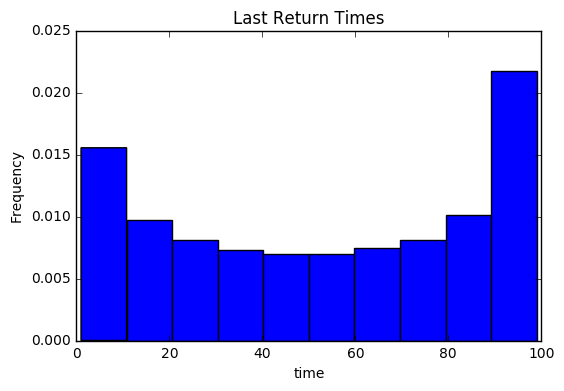

In [35]:
from numpy.random import randint
from scipy.special import gamma as gammaf

last = []
for i in range(100000):
    t_max = 100
    random_numbers = randint(0, 2, size=t_max)
    steps = np.where(random_numbers == 0, -1, +1)
    values = np.cumsum(steps)
    if 0 in values:
        last.append(np.where(values == 0)[0][-1])
ax = plt.hist(last,normed = True)
plt.title("Last Return Times")
plt.xlabel("time")
plt.ylabel("Frequency")
pass

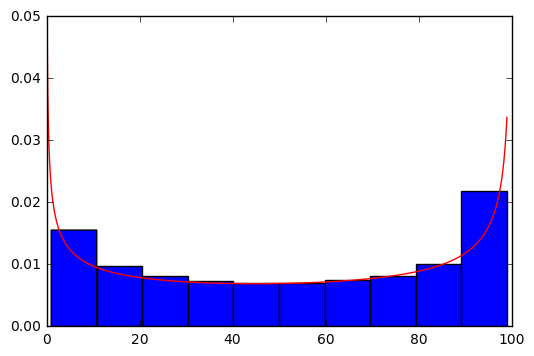

In [36]:
from scipy import stats
a,b,xx,yy=stats.beta.fit(last, loc =0, scale = 100)
x =np.linspace(0,max(last),len(last))
y = stats.beta.pdf(x,a,b,loc = 0, scale = 100)
plt.hist(last,normed = True)
plt.plot(x,y, 'r')
plt.ylim([0,0.05])
plt.show()
pass

**Exercise 4 (20 points)**

The Cauchy distribution is given by 
$$
f(x) = \frac{1}{\pi (1 + x^2)}, \ \ -\infty \lt x \lt \infty 
$$

- Integrate the tail probability $P(X > 2)$ using Monte Carlo
    1. Sampling from the Cauchy distribution directly
    2. Sampling from the uniform distribution using an appropriate change of variables
- Plot the 95% CI for the Monte Carlo estimates for n = 1 to 1000
    1. For sampling from the Cauchy distribution using mulitple Monte Carlo sequences
    2. For sampling from the uniform distribution using bootstrap samples of a single Monte Carlo sequence




In [37]:
#Sampling from the Cauchy distribution directly
n = 1000
x = stats.cauchy().rvs(n)
h_mc = 1.0/n * np.sum(x > 2)
h_mc

0.152

In [38]:
#Sampling from the uniform distribution using an appropriate change of variables
y = stats.uniform().rvs(n)
h_cv = 1.0/n * np.sum(2.0/(np.pi * (4 + y**2)))
h_cv

0.14814818118798007

In [39]:
#For sampling from the Cauchy distribution using mulitple Monte Carlo sequences
def f(x):
    return 1.0/ (np.pi *(1+ x**2))
n = 1000
reps = 1000
x = f(np.random.random((n, reps)))
y = 1/np.arange(1, n+1)[:,None] * np.cumsum(x, axis=0)
upper, lower = np.percentile(y, [2.5, 97.5], axis=1)


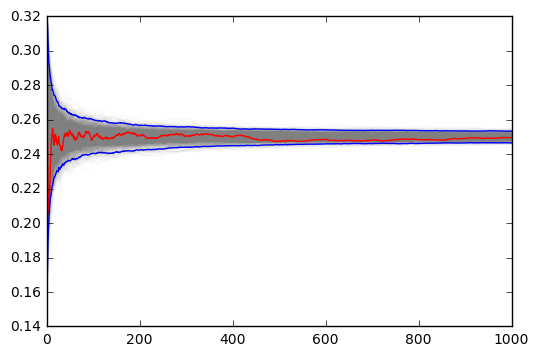

In [40]:
plt.plot(np.arange(1, n+1), y, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), y[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

In [41]:
#For sampling from the uniform distribution using bootstrap samples of a single Monte Carlo sequence
xb = np.random.choice(x[:,0], (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

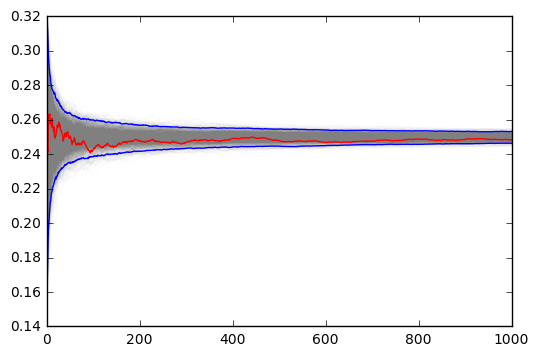

In [42]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

**Exercise 5 (20 points)**.

Estimate the following integral using Monte Carlo integration

$$
\int_{-\infty}^{\infty} x^2 \frac{1}{2}e^{-|x|} dx
$$

Hint: See notes on importance sampling and figure.

![Hint](./dexp.png)

In [43]:
def f(x):
    return x**2 * 1/2 * np.exp(-abs(x))

In [44]:
#use importance sampling
n = 10000
y = stats.norm(0,2).rvs(n)
h_is = 1.0/n * np.sum(f(y)/stats.norm(0,2).pdf(y))
# estimate 
h_is

1.980188558893875